In [1]:
import os 
import re 
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt



In [2]:
def parse_teresort_output(file_path):
    metrics = {}
    job_start_time = None
    job_end_time = None
    yarn_start_time = None

    # Pattern to capture key=value lines
    kv_pattern = re.compile(r"^\s+([^=]+)=([0-9]+)")

    # Pattern to capture start and end timestamps
    start_pattern = re.compile(r"^(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d+).*terasort\.TeraSort: starting")
    end_pattern = re.compile(r"^(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d+).*terasort\.TeraSort: done")

    yarn_start_pattern = re.compile(r"^(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d+).*mapreduce\.Job: Running job")


    with open(file_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        # Match metrics
        kv_match = kv_pattern.match(line)
        if kv_match:
            key, value = kv_match.groups()
            metrics[key.strip()] = int(value.strip())

        # Match start time
        if not job_start_time:
            start_match = start_pattern.match(line)
            if start_match:
                job_start_time = datetime.strptime(start_match.group(1), "%Y-%m-%d %H:%M:%S,%f")

        # Match YARN start time
        if not yarn_start_time:
            yarn_start_match = yarn_start_pattern.match(line)
            if yarn_start_match:
                yarn_start_time = datetime.strptime(yarn_start_match.group(1), "%Y-%m-%d %H:%M:%S,%f")

        # Match end time
        end_match = end_pattern.match(line)
        if end_match:
            job_end_time = datetime.strptime(end_match.group(1), "%Y-%m-%d %H:%M:%S,%f")

   
    if job_start_time and job_end_time:
        duration_seconds = (job_end_time - job_start_time).total_seconds()
        metrics['WallClockTimeSeconds'] = duration_seconds
    if yarn_start_time and job_end_time:
        duration_seconds = (job_end_time - yarn_start_time).total_seconds()
        metrics['PureJobDurationSeconds'] = duration_seconds
    else:
        metrics['WallClockTimeSeconds'] = None

    return metrics


def get_hadoop_results(log_files):
    results = []

    for file in log_files:
        num_workers_match = re.search(r"terasort_output_(\d+)_node", os.path.basename(file))

        match = re.search(r'1-(\d+) terasort', file)

        if match:
            num_workers_match = match 
        
    
        if num_workers_match:
            # print(f"Processing file: {file}")
            terasort_metrics = parse_teresort_output(file)

            num_workers = int(num_workers_match.group(1))
            # print(f"Number of workers: {num_workers}")

            # Calculate aggregate resource utilization
            vcore_total = terasort_metrics.get('Total vcore-milliseconds taken by all map tasks', 0) + terasort_metrics.get('Total vcore-milliseconds taken by all reduce tasks', 0)
            agg_resource_util = vcore_total / num_workers
            # print(f"Aggregate resource utilization: {agg_resource_util}")
            # Calculate shuffle throughput 
            shuffle_bytes = terasort_metrics.get('Reduce shuffle bytes', 0)
            reduce_time_ms = terasort_metrics.get('Total time spent by all reduce tasks (ms)', 0)
            wall_time = terasort_metrics.get('WallClockTimeSeconds', 0)
            shuffle_throughput = shuffle_bytes / (wall_time ) / (1024 ** 2)
            # print(f"Shuffle throughput: {shuffle_throughput} MB/s")

            # Calculate memory utilization

            mem_snapshot = terasort_metrics.get('Physical memory (bytes) snapshot', 0)
            mem_per_worker = mem_snapshot / num_workers / (1024 ** 2) 
            # print(f"Memory utilization per worker: {mem_per_worker} MB")


                    # Calculate I/O efficiency

            bytes_read = terasort_metrics.get('HDFS: Number of bytes read', 0)
            bytes_written = terasort_metrics.get('HDFS: Number of bytes written', 0)

            io_throughput = (bytes_read + bytes_written) / (wall_time * num_workers * 1024**2)
            # print("HDFS I/O per worker (MB/s):", round(io_throughput, 2))


            # Calculate CPU utilization 
            cpu_time = terasort_metrics.get('CPU time spent (ms)', 0)

            cpu_efficiency = cpu_time / (num_workers * wall_time * 1000)
            # print("CPU Utilization Efficiency:", round(cpu_efficiency, 2))


            # Task reliability
            killed_tasks = terasort_metrics.get('Killed map tasks', 0)

            killed_per_worker = killed_tasks / num_workers
            # print("Killed tasks per worker:", killed_per_worker)


            row = {
                'num_workers': num_workers,
                'agg_resource_util': agg_resource_util,
                'shuffle_throughput': shuffle_throughput,
                'mem_util': mem_per_worker,
                'io_throughput': io_throughput,
                'cpu_efficiency': cpu_efficiency,
                'task_reliability': killed_per_worker,
                'wall_time': wall_time,
                'pure_job_duration': terasort_metrics.get('PureJobDurationSeconds', 0),
            }
            results.append(row)
        else:
            num_workers = None

    return results
        

In [3]:
def parse_spark_terasort_output(file_path): 
    with open(file_path, 'r') as f:
        lines = f.readlines()


    start_idx = None
    end_idx = None

    for i, line in enumerate(lines):
        if "Spark TeraSort Benchmark" in line:
            start_idx = i + 1
        elif start_idx is not None and re.match(r"=+", line):
            end_idx = i
            break


    results = {}


    if start_idx is not None and end_idx is not None:
        for line in lines[start_idx:end_idx]:
            match = re.match(r'^(.*?):\s*(.*)$', line)

            if match:
                key, value = match.groups()
                if key.strip() == "Number of Workers":
                    results['num_workers'] = int(value.split()[0])
                elif key.strip() == "Wall Time":
                    results['wall_time'] = float(value.split()[0])
                elif key.strip() == "Shuffle Throughput":
                    results['shuffle_throughput'] = float(value.split()[0])
                elif key.strip() == "Aggregate Resource Utilization":
                    results['agg_resource_util'] = float(value.split()[0])
                elif key.strip() == "HDFS I/O Throughput per Worker":
                    results['io_throughput'] = float(value.split()[0])
                elif key.strip() == "Memory Utilization per Worker":
                    results['mem_util'] = float(value.split()[0])


    return results

def get_spark_results(spark_log_files):
    spark_results = []

    for file in spark_log_files:
        row = parse_spark_terasort_output(file)
        if row:
            spark_results.append(row)

    return spark_results

In [4]:

hadoop_docker_log_dir = './hadooplogs/hadooplogs_docker' 
spark_docker_log_dir = './sparklogs/sparklogs_docker'
hadoop_jetstream_log_dir = './hadooplogs/hadooplogs_jetstream'
spark_jetstream_log_dir = './sparklogs/sparklogs_jetstream' 

hadoop_docker_log_files = [os.path.join(hadoop_docker_log_dir, f) for f in os.listdir(hadoop_docker_log_dir) if os.path.isfile(os.path.join(hadoop_docker_log_dir, f)) ]

spark_docker_log_files = [os.path.join(spark_docker_log_dir, f) for f in os.listdir(spark_docker_log_dir) if os.path.isfile(os.path.join(spark_docker_log_dir, f))]

hadoop_jetstream_log_files = [os.path.join(hadoop_jetstream_log_dir, f) for f in os.listdir(hadoop_jetstream_log_dir) if os.path.isfile(os.path.join(hadoop_jetstream_log_dir, f))]
spark_jetstream_log_files = [os.path.join(spark_jetstream_log_dir, f) for f in os.listdir(spark_jetstream_log_dir) if os.path.isfile(os.path.join(spark_jetstream_log_dir, f))]




spark_docker_results = get_spark_results(spark_docker_log_files)
hadoop_docker_results = get_hadoop_results(hadoop_docker_log_files)
spark_jetstream_results = get_spark_results(spark_jetstream_log_files)
hadoop_jetstream_results = get_hadoop_results(hadoop_jetstream_log_files)

spark_docker_df = pd.DataFrame(spark_docker_results)
hadoop_docker_df = pd.DataFrame(hadoop_docker_results)
spark_jetstream_df = pd.DataFrame(spark_jetstream_results)
hadoop_jetstream_df = pd.DataFrame(hadoop_jetstream_results)

spark_docker_df = spark_docker_df.sort_values('num_workers')
hadoop_docker_df = hadoop_docker_df.sort_values('num_workers')
spark_jetstream_df = spark_jetstream_df.sort_values('num_workers')
hadoop_jetstream_df = hadoop_jetstream_df.sort_values('num_workers')


In [5]:
def plot_curves(metric, y_label):
    plt.figure(figsize=(8, 6)) 

    # Plot 4 curves
    plt.plot(spark_docker_df['num_workers'], spark_docker_df[metric], marker='o', label='Spark Docker')
    plt.plot(hadoop_docker_df['num_workers'], hadoop_docker_df[metric], marker='s', label='Hadoop Docker')
    plt.plot(spark_jetstream_df['num_workers'], spark_jetstream_df[metric], marker='^', label='Spark Jetstream2')
    plt.plot(hadoop_jetstream_df['num_workers'], hadoop_jetstream_df[metric], marker='x', label='Hadoop Jetstream2')

    # Labels and title
    plt.xlabel('Number of Workers', fontsize=16)
    plt.ylabel(f'{y_label}', fontsize=16)
    plt.title(f'{y_label} vs Number of Workers', fontsize=20)
    plt.legend(fontsize=16)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

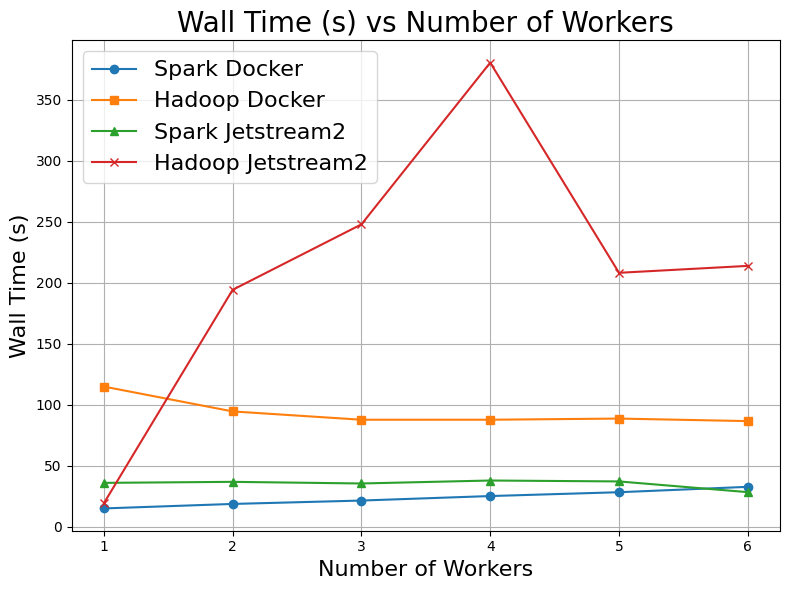

In [6]:
plot_curves('wall_time', 'Wall Time (s)')

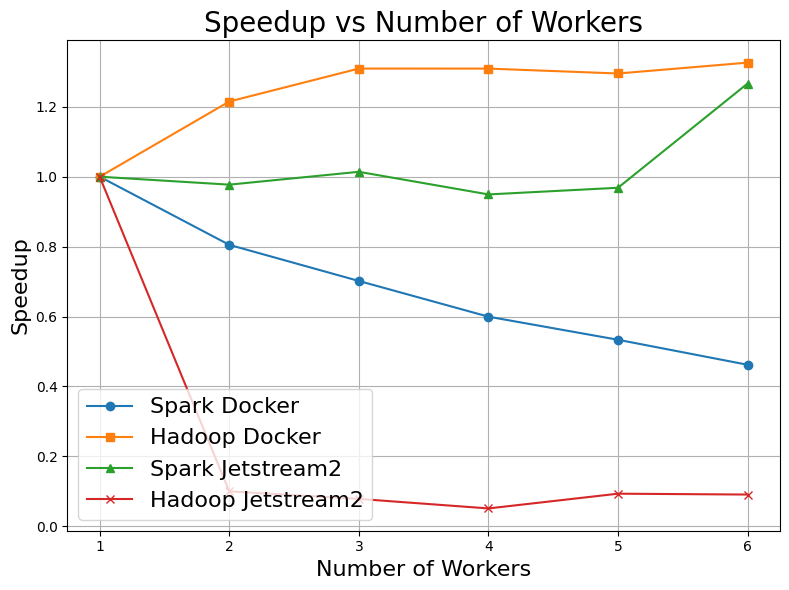

In [7]:
# plot speedup vs number of workers
T1_spark_docker = spark_docker_df.loc[spark_docker_df['num_workers'] == 1, 'wall_time'].values[0]
spark_docker_df['speedup'] = T1_spark_docker / spark_docker_df['wall_time']

T1_hadoop_docker = hadoop_docker_df.loc[hadoop_docker_df['num_workers'] == 1, 'wall_time'].values[0]
hadoop_docker_df['speedup'] = T1_hadoop_docker / hadoop_docker_df['wall_time']

T1_spark_jetstream = spark_jetstream_df.loc[spark_jetstream_df['num_workers'] == 1, 'wall_time'].values[0]
spark_jetstream_df['speedup'] = T1_spark_jetstream / spark_jetstream_df['wall_time']

T1_hadoop_jetstream = hadoop_jetstream_df.loc[hadoop_jetstream_df['num_workers'] == 1, 'wall_time'].values[0]
hadoop_jetstream_df['speedup'] = T1_hadoop_jetstream / hadoop_jetstream_df['wall_time']

plot_curves('speedup', 'Speedup')

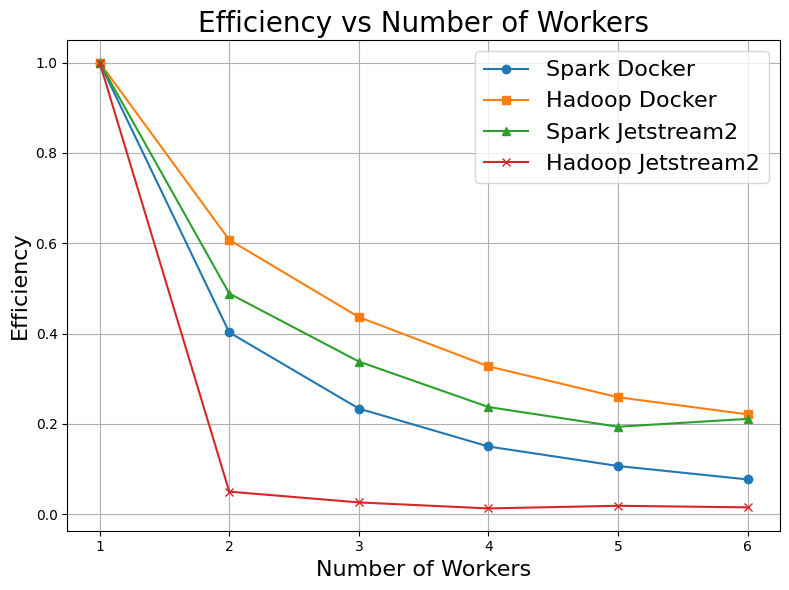

In [8]:
spark_docker_df['efficiency'] = spark_docker_df['speedup'] / spark_docker_df['num_workers']
hadoop_docker_df['efficiency'] = hadoop_docker_df['speedup'] / hadoop_docker_df['num_workers']
spark_jetstream_df['efficiency'] = spark_jetstream_df['speedup'] / spark_jetstream_df['num_workers']
hadoop_jetstream_df['efficiency'] = hadoop_jetstream_df['speedup'] / hadoop_jetstream_df['num_workers']

plot_curves('efficiency', 'Efficiency')

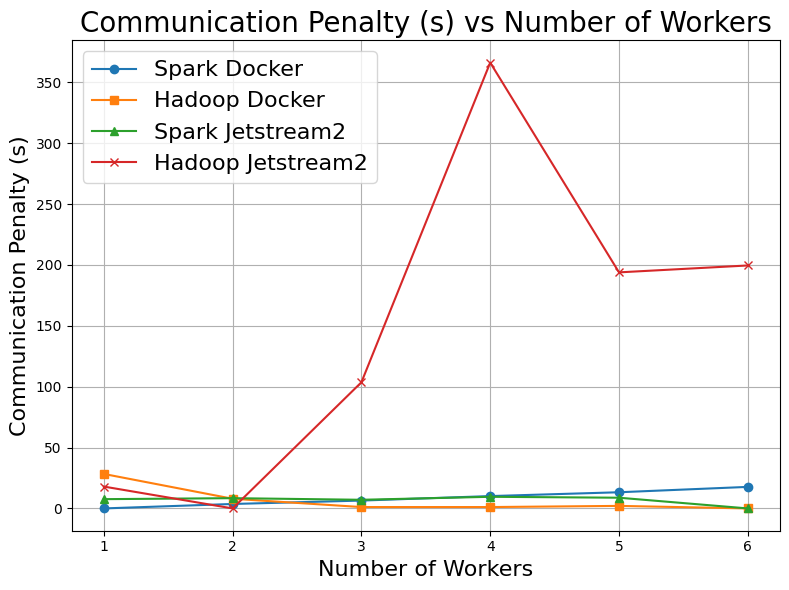

In [9]:
# Find maximum shuffle throughput across all workers
max_shuf_spark_docker = spark_docker_df['shuffle_throughput'].max()
max_shuf_hadoop_docker = hadoop_docker_df['shuffle_throughput'].max()
max_shuf_spark_jetstream = spark_jetstream_df['shuffle_throughput'].max()
max_shuf_hadoop_jetstream = hadoop_jetstream_df['shuffle_throughput'].max()

# Compute communication penalty
spark_docker_df['comm_penalty'] = spark_docker_df['wall_time'] * (1 - spark_docker_df['shuffle_throughput'] / max_shuf_spark_docker)
hadoop_docker_df['comm_penalty'] = hadoop_docker_df['wall_time'] * (1 - hadoop_docker_df['shuffle_throughput'] / max_shuf_hadoop_docker)
spark_jetstream_df['comm_penalty'] = spark_jetstream_df['wall_time'] * (1 - spark_jetstream_df['shuffle_throughput'] / max_shuf_spark_jetstream)
hadoop_jetstream_df['comm_penalty'] = hadoop_jetstream_df['wall_time'] * (1 - hadoop_jetstream_df['shuffle_throughput'] / max_shuf_hadoop_jetstream)
plot_curves('comm_penalty', 'Communication Penalty (s)')

In [10]:
spark_results = get_spark_results(spark_log_files)
spark_df = pd.DataFrame(spark_results)


spark_metrics = spark_results[0].keys() - {'num_workers'}
spark_metrics = list(spark_metrics)

spark_df = spark_df.sort_values('num_workers')

for metric in spark_metrics:
    plt.figure()
    plt.plot(spark_df['num_workers'], spark_df[metric], marker='o')
    plt.xlabel('Number of Workers (Datanodes)')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.title(f'{metric.replace("_", " ").title()} vs Number of Workers')
    plt.grid(True)
    plt.tight_layout()


plt.show()


NameError: name 'spark_log_files' is not defined

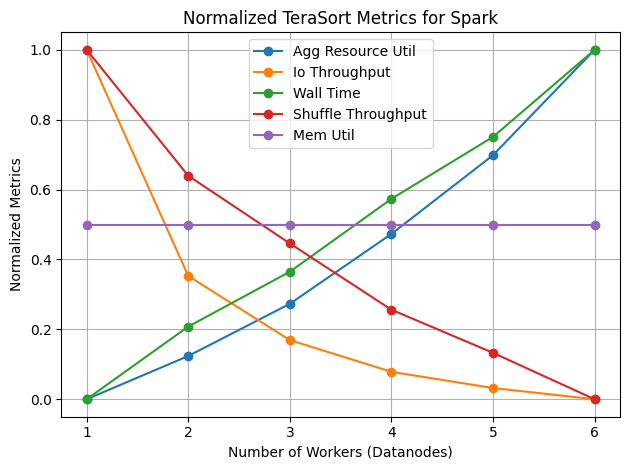

In [ ]:
normalized_spark_df = spark_df.copy()

for metric in spark_metrics:
    col = normalized_spark_df[metric]
    col_min = col.min()
    col_max = col.max()
    if col_max != col_min:
        normalized_spark_df[metric] = (col - col.min()) / (col.max() - col.min())
    else:
        normalized_spark_df[metric] = 0.5

for metric in spark_metrics:
    plt.plot(normalized_spark_df['num_workers'], normalized_spark_df[metric], marker='o', label=metric.replace('_', ' ').title())
plt.xlabel('Number of Workers (Datanodes)')
plt.ylabel('Normalized Metrics')
plt.title('Normalized TeraSort Metrics for Spark')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

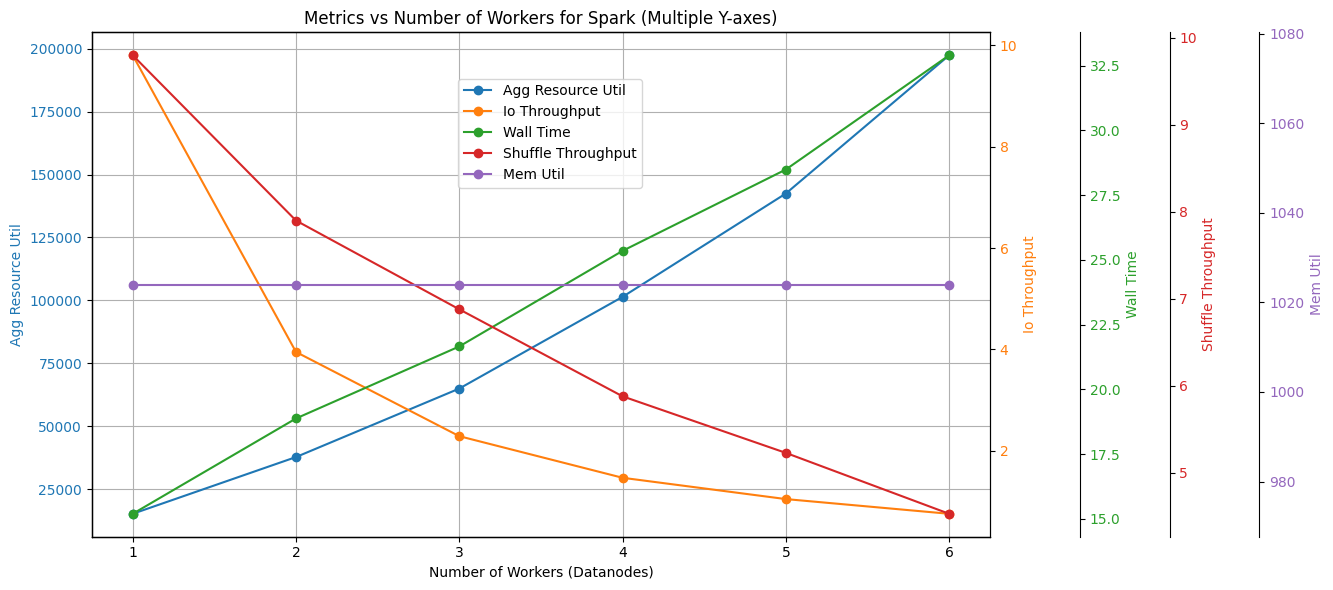

In [ ]:
fig, ax1 = plt.subplots(figsize=(14, 6))

colors = plt.cm.tab10.colors  # 10 distinct colors
axes = [ax1]  # store all axes
lines = []

# Plot the first metric
metric = spark_metrics[0]
color = colors[0]
line, = ax1.plot(spark_df['num_workers'], spark_df[metric], marker='o', color=color, label=metric.replace('_', ' ').title())
ax1.set_ylabel(metric.replace('_', ' ').title(), color=color)
ax1.tick_params(axis='y', labelcolor=color)
lines.append(line)

# Plot remaining metrics
for i, metric in enumerate(spark_metrics[1:], start=1):
    ax = ax1.twinx()  
    axes.append(ax)
    
    ax.spines["right"].set_position(("axes", 1 + 0.1 * (i-1)))
    
    color = colors[i % len(colors)]
    line, = ax.plot(spark_df['num_workers'], spark_df[metric], marker='o', color=color, label=metric.replace('_', ' ').title())
    
    ax.set_ylabel(metric.replace('_', ' ').title(), color=color)
    ax.tick_params(axis='y', labelcolor=color)
    
    lines.append(line)

ax1.set_xlabel('Number of Workers (Datanodes)')
plt.title('Metrics vs Number of Workers for Spark (Multiple Y-axes)')
ax1.grid(True)

labels = [line.get_label() for line in lines]

plt.legend(lines, labels, loc='center left', bbox_to_anchor=(0.4, 0.8))

plt.tight_layout()
plt.show()

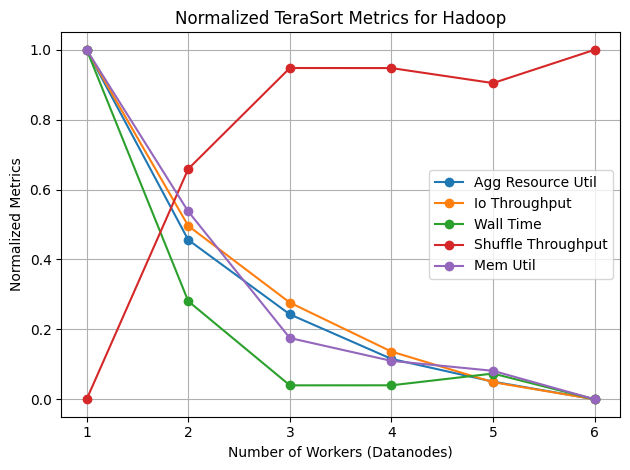

In [ ]:
hadoop_results = get_hadoop_results(hadoop_log_files)

hadoop_df = pd.DataFrame(hadoop_results)
hadoop_df = hadoop_df.sort_values('num_workers')

normalized_hadoop_df = hadoop_df.copy()
for metric in spark_metrics:
    col = normalized_hadoop_df[metric]
    normalized_hadoop_df[metric] = (col - col.min()) / (col.max() - col.min())


for metric in spark_metrics:
    plt.plot(normalized_hadoop_df['num_workers'], normalized_hadoop_df[metric], marker='o', label=metric.replace('_', ' ').title())
plt.xlabel('Number of Workers (Datanodes)')
plt.ylabel('Normalized Metrics')
plt.title('Normalized TeraSort Metrics for Hadoop')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print(spark_df)

   num_workers  wall_time  shuffle_throughput  agg_resource_util  mem_util  \
5            1      15.20                9.80           15202.13    1024.0   
2            2      18.88                7.90           37751.25    1024.0   
3            3      21.66                6.88           64966.02    1024.0   
1            4      25.35                5.88          101406.23    1024.0   
0            5      28.49                5.23          142473.35    1024.0   
4            6      32.90                4.53          197409.90    1024.0   

   io_throughput  
5           9.80  
2           3.95  
3           2.29  
1           1.47  
0           1.05  
4           0.76  


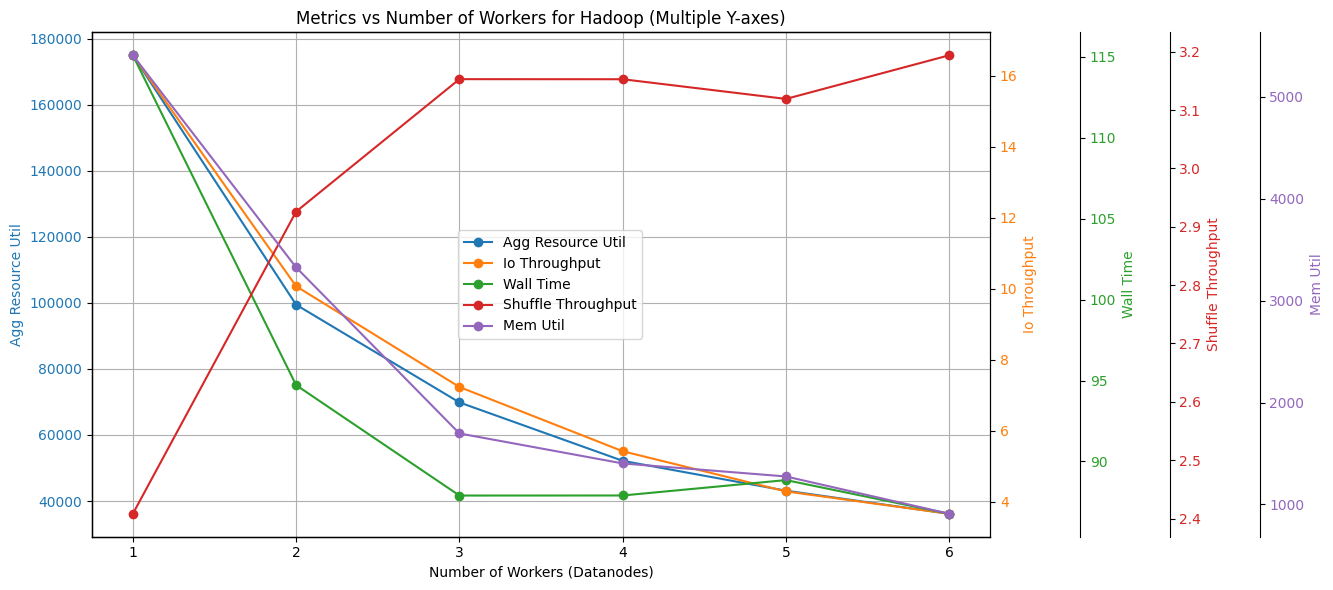

In [ ]:
fig, ax1 = plt.subplots(figsize=(14, 6))

colors = plt.cm.tab10.colors  # 10 distinct colors
axes = [ax1]  # store all axes
lines = []

# Plot the first metric
metric = spark_metrics[0]
color = colors[0]
line, = ax1.plot(hadoop_df['num_workers'], hadoop_df[metric], marker='o', color=color, label=metric.replace('_', ' ').title())
ax1.set_ylabel(metric.replace('_', ' ').title(), color=color)
ax1.tick_params(axis='y', labelcolor=color)
lines.append(line)

# Plot remaining metrics
for i, metric in enumerate(spark_metrics[1:], start=1):
    ax = ax1.twinx()  
    axes.append(ax)
    
    ax.spines["right"].set_position(("axes", 1 + 0.1 * (i-1)))
    
    color = colors[i % len(colors)]
    line, = ax.plot(spark_df['num_workers'], hadoop_df[metric], marker='o', color=color, label=metric.replace('_', ' ').title())
    
    ax.set_ylabel(metric.replace('_', ' ').title(), color=color)
    ax.tick_params(axis='y', labelcolor=color)
    
    lines.append(line)

ax1.set_xlabel('Number of Workers (Datanodes)')
plt.title('Metrics vs Number of Workers for Hadoop (Multiple Y-axes)')
ax1.grid(True)

labels = [line.get_label() for line in lines]

plt.legend(lines, labels, loc='center left', bbox_to_anchor=(0.4, 0.5))

plt.tight_layout()
plt.show()

